In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
# Cargar librerias

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import time

In [5]:
# Ruta raíz
PATH = "/content/drive/My Drive/DatosColab/pix2pix_flowers"

# Ruta datos de entrada
INPATH = PATH + '/inputFlowers'

# Ruta datos de salida
OUPATH = PATH + '/targetFlowers'

# Ruta de los checkpoints
CKPATH = PATH + '/checkpoints'

imgurls = !ls -1 "{INPATH}"

n = 120
train_n = round(n*0.80)

# Listado randomizado
randurls = np.copy(imgurls)

np.random.seed(23)
np.random.shuffle(randurls)

# Partición train/test
tr_urls = randurls[:train_n]
ts_urls = randurls[train_n:n]

print(len(imgurls), len(tr_urls), len(ts_urls))

7734 96 24


In [0]:
IMG_WIDTH = 256
IMG_HEIGHT = 256

# Reescalar imagenes
def resize(inimg, tgimg, height, width):
  
  inimg = tf.image.resize(inimg, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  tgimg = tf.image.resize(tgimg, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return inimg, tgimg

In [0]:
# Normalizar [-1, 1]
def normalize(inimg, tgimg):
  
  inimg = (inimg / 127.5) - 1
  tgimg = (tgimg / 127.5) - 1

  return inimg, tgimg

In [0]:
def random_crop(inimg, tgimg):
  stacked_image = tf.stack([inimg, tgimg], axis=0)
  cropped_image = tf.image.random_crop( stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

In [0]:
@tf.function()
def random_jitter(inimg, tgimg):
  
  # resizing to 286 x 286 x 3
  inimg, tgimg = resize(inimg, tgimg, 286, 286)
  
  # randomly cropping to 256 x 256 x 3
  inimg, tgimg = random_crop(inimg, tgimg)

  if tf.random.uniform(()) > 0.5:
    # random mirroring
    inimg = tf.image.flip_left_right(inimg)
    tgimg = tf.image.flip_left_right(tgimg)

  return inimg, tgimg

In [0]:
def load_image(filename, augment = True):
  
  inimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(INPATH + '/' + filename)),tf.float32)[...,:3]
  tgimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(OUPATH + '/' + filename)),tf.float32)[...,:3]
  
  inimg, tgimg = resize(inimg, tgimg, IMG_HEIGHT, IMG_WIDTH)
  
  if augment:
    inimg, tgimg = random_jitter(inimg, tgimg)
    
  inimg, tgimg = normalize(inimg, tgimg)
  
  return inimg, tgimg

In [0]:
def load_train_image(filename):
  return load_image(filename, True)

def load_test_image(filename):
  return load_image(filename, False)

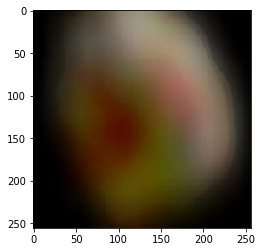

In [0]:
plt.imshow(((load_train_image(randurls[0])[0] + 1)/2))

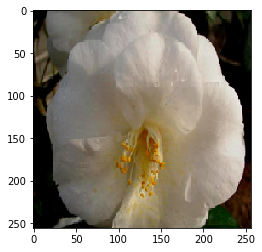

In [0]:
plt.imshow(((load_train_image(randurls[0])[1] + 1)/2))

Input Pipeline

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices(tr_urls)
train_dataset = train_dataset.map(load_train_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(1)

test_dataset = tf.data.Dataset.from_tensor_slices(ts_urls)
test_dataset = test_dataset.map(load_test_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(1)

# for inimg, tgimg in train_dataset.take(5):
#   plt.imshow(((tgimg[0,...]) + 1) / 2)
#   plt.show()

In [0]:
def downsample(filters, size, apply_batchnorm=True):
  
  result = tf.keras.Sequential()
  
  initializer = tf.random_normal_initializer(0., 0.02)
  
  # Capa convolucional
  result.add(tf.keras.layers.Conv2D(filters,
                                    kernel_size = size,
                                    strides = 2,
                                    padding = 'same',
                                    kernel_initializer=initializer,                               
                                    use_bias=not apply_batchnorm))
                                    
  if apply_batchnorm:
    # Capa de BatchNorm
    result.add(tf.keras.layers.BatchNormalization())
    
  result.add(tf.keras.layers.LeakyReLU())
  
  return result

In [0]:
def upsample(filters, size, apply_dropout=False):
  
  result = tf.keras.Sequential()
  
  initializer = tf.random_normal_initializer(0., 0.02)
  
  # Capa convolucional
  result.add(tf.keras.layers.Conv2DTranspose(filters,
                                             kernel_size = size,
                                             strides = 2,
                                             padding = 'same',
                                             kernel_initializer=initializer,                               
                                             use_bias=False))
  # Capa de BatchNorm
  result.add(tf.keras.layers.BatchNormalization())
  
  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.5))
    
  result.add(tf.keras.layers.LeakyReLU())
  
  return result

In [0]:
def Generator():
  
  inputs = tf.keras.layers.Input(shape=[None,None,3])
  
  down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128, 4), # (bs, 64, 64, 128)
    downsample(256, 4), # (bs, 32, 32, 256)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    upsample(128, 4), # (bs, 64, 64, 256)
    upsample(64, 4), # (bs, 128, 128, 128)
  ]
  
  initializer = tf.random_normal_initializer(0., 0.02)
  
  last = tf.keras.layers.Conv2DTranspose(filters = 3,
                                         kernel_size = 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)
  
  concat = tf.keras.layers.Concatenate()

  x = inputs
  
  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = concat([x, skip])

  last = last(x)

  return tf.keras.Model(inputs=inputs, outputs=last)

generator = Generator()

Build the Discriminator

In [0]:
def Discriminator():
  
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[None, None, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[None, None, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
  down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)
  down4 = downsample(512, 4)(down3) # (bs, 32, 32, 512)

  last = tf.keras.layers.Conv2D(filters = 1,
                                kernel_size = 4,
                                strides=1,
                                kernel_initializer=initializer,
                                padding = 'same')(down4) 
  
  return tf.keras.Model(inputs=[inp, tar], outputs=last)

discriminator = Discriminator()

Define the loss functions and the optimizer

In [0]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [0]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [0]:
import os

checkpoint_prefix = os.path.join(CKPATH, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

#checkpoint.restore(tf.train.latest_checkpoint(CKPATH)).assert_consumed()

In [0]:
def generate_images(model, test_input, tar, save_filename = False, display_imgs = True):

  prediction = model(test_input, training=True)

  if save_filename:
    tf.keras.preprocessing.image.save_img(PATH + '/output/' + save_filename + '.jpg', prediction[0,...])
  
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  if display_imgs:
    for i in range(3):
      plt.subplot(1, 3, i+1)
      plt.title(title[i])
      # getting the pixel values between [0, 1] to plot it.
      plt.imshow(display_list[i] * 0.5 + 0.5)
      plt.axis('off')
        
  plt.show()
  time.sleep(3)

In [0]:
@tf.function
def train_step(input_image, target):
  
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    
    output_image = generator(input_image, training=True)

    output_gen_discr = discriminator([output_image, input_image], training=True)

    output_trg_discr = discriminator([target, input_image], training=True)

    discr_loss = discriminator_loss(output_trg_discr, output_gen_discr)

    gen_loss = generator_loss(output_gen_discr, output_image, target)
    
    generator_grads = gen_tape.gradient(gen_loss, generator.trainable_variables)
    
    discriminator_grads = disc_tape.gradient(discr_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_grads, generator.trainable_variables))
    
    discriminator_optimizer.apply_gradients(zip(discriminator_grads, discriminator.trainable_variables))


In [0]:
LAMBDA = 100

In [0]:
from IPython.display import clear_output

def train(dataset, epochs):
  for epoch in range(epochs):
    
    imgi = 0
    
    # Train
    for input_image, target in dataset:
      print('epoch' + str(epoch) + '- train:' + str(imgi) + '/' + str(len(tr_urls)))
      imgi += 1
      train_step(input_image, target)
      clear_output(wait=True)
    
    imgi = 0
    for inp, tar in test_dataset.take(1):
      generate_images(generator, inp, tar, str(imgi) + '_' + str(epoch), display_imgs=True)
      imgi += 1

    # saving (checkpoint) the model every 20 epochs
    if (epoch + 1) % 50 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

In [0]:
train(train_dataset, 250)

epoch18- train:95/96


In [6]:
ts_urls[0]

'image_05642.jpg'